# ライブラリの挿入

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
%matplotlib inline
np.set_printoptions(threshold=np.inf)
from sklearn.neighbors import KNeighborsClassifier

# SOM関数

In [2]:
class SOM():
    
    def __init__(self, services, N, times, seed=None,):
        self.services = np.array(services) #services をnumpy arrayに変換
        self.n_service = self.services.shape[0] #serviceのデータ数
        self.N = N #マップの大きさ
        self.times = times #学習回数
        if not seed is None:
            np.random.seed(seed) #seedが指定されていれば、seedを取得
            
        x, y = np.meshgrid(range(self.N), range(self.N)) # xは、[0,1,2,...19]が20個　yは、[0,0,0,...,0][1,1,1,1...,1]を19まで
        self.c = np.hstack((x.flatten()[:, np.newaxis],
                            y.flatten()[:, np.newaxis]))#xとyを合わせて座標軸の作成array[[0,1],[0,2],...,[19,19]]
        self.nodes = self.services #19*19の三値の乱数を作成
    
    
        #W(t+1)=W(t)+Φ(t)L(t)(V(t)-W(t))
        
    def train(self):
        for var in range(self.times):
            np.random.shuffle(self.services)
            for i, service in enumerate(self.services): #self.techers の中にある全ての要素をserviceとして取り出し #iはtとして
                bmu = self._best_matching_unit(service) #bmuを見つける座標をbmuに格納
                d = np.linalg.norm(self.c - bmu, axis=1) #dの中にはbmuと各点間の距離を格納している
                L = self._learning_ratio(i) #ここの中にL(t)を格納
                S = self._learning_radius(i, d) #ここの中にΦ(t)を格納
                self.nodes += L * S[:, np.newaxis] * (service - self.nodes) #W(t)（Sは場所に依存する配列）
        return self.nodes        #compute all norms (square)


    def _best_matching_unit(self, service):
        norms = np.linalg.norm(self.nodes - service, axis=1) #全てのノードとserviceを比較して、ノルムを計算
        bmu = np.argmin(norms) #argment with minimum element　normsのなかで一番小さいノルムを取得 ここで返すのは、インデックスのみ
        return np.unravel_index(bmu,(self.N, self.N)) #返す値は、インデックス番号がどれに値するかという情報

    #σ(t)
    def _neighbourhood(self, t):#neighbourhood radious 更新するノード数は徐々に減っていく
        halflife = float(self.n_service/4) #for testing
        initial  = float(self.N/2) #initial=20/2=10
        return initial*np.exp(-t/halflife) #10exp(-t/250)のレートで下がっていくt=0で10,t=250で5
    
    #L(t)
    def _learning_ratio(self, t): #learning関数
        halflife = float(self.n_service/4) #for testing
        initial  = 0.1
        return initial*np.exp(-t/halflife) #初期の更新係数は0.1そこから、だんだん更新度合いは減少していく
    
    #Φ(t)=exp((-dist^2)/(2σ^2(t)))
    #distはBMUからの距離でいい
    def _learning_radius(self, t, d):
        # d is distance from BMU
        s = self._neighbourhood(t) #sは、時間tの近傍半径
        return np.exp(-d**2/(2*s**2))  #近傍関数の値を返す（近ければ近いほど、大きい）Sも配列になる
    

# Determine関数
場所がDeterminできた場合はその場所の番号を、それ以外の場合は0を返す関数

In [3]:
class DETERMINE():
    
    # servicesは入力データ
    # NはDeterministicな入力値の数
    # （例）
    # services[0] = [2,1,3,1,2,0,4,23,2,243,,54,213]
    #                N,N,N,N   
    
    def __init__(self, services, N):
        self.services = np.array(services) # services
        self.n_service = self.services.shape[0] # おそらく、serviceのデータ数
        self.N = N # Deterministicな値の数
        self.d_place = np.array([])# 
    
    
    def train(self):
        for i, service in enumerate(self.services): # servicesをserviceごとに分ける。iはserviceごとに1ずつ加算される
            for j in range(self.N): # serviceをattributeごとに分ける。
                if j == 0: # 初めてのattributeの場合は、d_placeの中に入れる
                    self.d_place = np.append(self.d_place, service[j])
                else:
                    if self.d_place[i] != service[j]:
                        self.d_place[i] = np.nan
        return self.d_place

# kNN関数

In [4]:
class KNN(): 
    
    def __init__(self, det_labels,som_nodes, new_comer, N):
        self.som_nodes = som_nodes
        self.d_labels = det_labels # som nodes
        self.new_comer = new_comer # おそらく、serviceのデータ数
        self.N = N # Deterministicな値の数 
        self.nearby_places = np.array([]) # self.nearby_placesには、入っている周りの座標が入っている
        self.places = np.array([])#nearby_placesの実行位置を格納
        self.score_0 = 0#ユークリッド距離を格納
        self.score_2 = 0
        self.score_4 = 0
        self.score_6 = 0
        self.score_8 = 0
        self.score_10 = 0
        self.scores = np.array([]) #競合した者たちのスコアを格納
    
    def train(self):
        # 
        bmu = self._best_matching_unit(self.new_comer)
        bmu_place = np.asarray(bmu)
        bmu_upleft = np.array([bmu[0] - 1, bmu[1] - 1])
        bmu_up = np.array([bmu[0] - 1, bmu[1]])
        bmu_upright = np.array([bmu[0] - 1, bmu[1] + 1])
        bmu_left = np.array([bmu[0], bmu[1] - 1])
        bmu_right = np.array([bmu[0], bmu[1] + 1])
        bmu_downleft = np.array([bmu[0] + 1, bmu[1] - 1])
        bmu_down = np.array([bmu[0] + 1, bmu[1]])
        bmu_downright = np.array([bmu[0] + 1, bmu[1] + 1])
        self.nearby_places = np.append(self.nearby_places,bmu_place)
        self.nearby_places = np.append(self.nearby_places,bmu_upleft)
        self.nearby_places = np.append(self.nearby_places,bmu_up)
        self.nearby_places = np.append(self.nearby_places,bmu_upright)
        self.nearby_places = np.append(self.nearby_places,bmu_left)
        self.nearby_places = np.append(self.nearby_places,bmu_right)
        self.nearby_places = np.append(self.nearby_places,bmu_downleft)
        self.nearby_places = np.append(self.nearby_places,bmu_down)
        self.nearby_places = np.append(self.nearby_places,bmu_downright)
        self.nearby_places = self.nearby_places.reshape((1,9,2))[0]
        self.nearby_places = np.delete(self.nearby_places, np.where(self.nearby_places < 0)[0], 0)
        self.nearby_places = np.delete(self.nearby_places, np.where(self.nearby_places > N - 1)[0], 0)
        # self.nearby_placesには、入っている周りの座標が入っている
        
        # 競合に備えて、各実行場所ごとのスコアを作成
        for i, nplace in enumerate(self.nearby_places):
            index = int(nplace[0] * self.N + nplace[1])
            d_label = self.d_labels[index]
            self.places = np.append(self.places,d_label)
            if d_label == 0.0:
                self.score_0 += np.linalg.norm(self.som_nodes[index] - self.new_comer)
            elif d_label == 0.2:
                self.score_2 +=  np.linalg.norm(self.som_nodes[index] - self.new_comer)
            elif d_label == 0.4:
                self.score_4 +=  np.linalg.norm(self.som_nodes[index] - self.new_comer)
            elif d_label == 0.6:
                self.score_6 += np.linalg.norm(self.som_nodes[index] - self.new_comer)
            elif d_label == 0.8:
                self.score_8 += np.linalg.norm(self.som_nodes[index] - self.new_comer)
            elif d_label == 1.0:
                self.score_10 += np.linalg.norm(self.som_nodes[index] - self.new_comer)

        # 実行場所から、nanは削除        
        self.places = np.delete(self.places, np.where(np.isnan(self.places))[0], 0)
        #最頻値を導出
        if len(self.places) != 0:
            self.result = self.calculate_mode(self.places)
        
            #scoresの中に各実行場所のスコアを入れ込む
            for i, result in enumerate(self.result):
                if result == 0.0:
                    self.scores = np.append(self.scores, self.score_0)
                if result == 0.2:
                    self.scores = np.append(self.scores, self.score_2)
                if result == 0.4:
                    self.scores = np.append(self.scores, self.score_4)
                if result == 0.6:
                    self.scores = np.append(self.scores, self.score_6)
                if result == 0.8:
                    self.scores = np.append(self.scores, self.score_8)
                if result == 1.0:
                    self.scores = np.append(self.scores, self.score_10)

            #一番スコアが小さいところを選べ
            min_length = min(self.scores)
            if min_length == self.score_0:
                self.result = 0.0
            elif min_length == self.score_2:
                self.result = 0.2
            elif min_length == self.score_4:
                self.result = 0.4
            elif min_length == self.score_6:
                self.result = 0.6
            elif min_length == self.score_8:
                self.result = 0.8
            elif min_length == self.score_10:
                self.result = 1.0
            return self.result
        else:
            self.result = "Anywhere"
            return "Anywhere"
        
    def _best_matching_unit(self, service):
        norms = np.linalg.norm(self.som_nodes - service, axis=1)
        bmu = np.argmin(norms)
        return np.unravel_index(bmu,(self.N, self.N))


    def calculate_mode(self,data):
        c = Counter(data)
        # すべての要素とその出現回数を取り出します。
        freq_scores = c.most_common()
        #c.most_common内の最も多い要素[0]の最大出現回数[1]を[0][1]で指定
        max_count = freq_scores[0][1]

        modes = []
         #出現回数と最大出現回数が等しいかを確認します。
        for num in freq_scores:
            if num[1] == max_count:
                modes.append(float(num[0]))
        return(modes)

# ランダムデータセットの作成
最初に、10種類のパラメータを持つデータを乱数で作成してみる。  
2種類のdeterministicなパラメータとそれ以外のnon-deterministicなパラメータを考える。  
### Determistic　　
匿名度合　許容遅延
### Non-Determistic
Rootユーザ数　たんいじかんあ

# 実際のテスト

In [8]:
services = np.array([])
sample = np.array([])
rand_int2 = np.array([])
probability = np.array([])
rand_choice = [0.0,0.2,0.4,0.6,0.8,1.0]
rand_int = np.random.choice(rand_choice, size=(100,1))
rand_float = np.random.rand(100,18)
for i in range(100):
    probability = np.append(probability,np.random.rand())
    if probability[i] > 0.2:
        rand_int2 = np.append(rand_int2, np.random.choice(rand_choice))
    else:
        rand_int2 = np.append(rand_int2, rand_int[i])
    sample = np.append(rand_int[i],rand_int2[i])
    sample = np.append(sample,rand_float[i])
    services = np.hstack((services,sample))
services = services.reshape((1, 100, 20))[0]
det_label = DETERMINE(services, N=2)
det_label.train()
som = SOM(services, N=10, times=1, seed=10)
N = 10

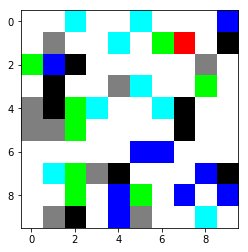

In [9]:
best_color = []
best_place = []
aaa = [1.0,1.0,1.0]
bbb = [0.0,1.0,0.0]
ccc = [0.0,0.0,1.0]
ddd = [0.0,0.0,0.0]
eee = [1.0,0.0,0.0]
fff = [0.5,0.5,0.5]
ggg = [0.0,1.0,1.0]
for j, service in enumerate(som.nodes):
    norms = np.linalg.norm(services - service, axis=1)
    bmu = np.argmin(norms)
    if np.isnan(det_label.d_place[bmu]):
        best_color.append(aaa)
        best_place.append(np.nan)
    if det_label.d_place[bmu] == 0.0:
        best_color.append(bbb)
        best_place.append(0.0)
    if det_label.d_place[bmu] == 0.2:
        best_color.append(ccc)
        best_place.append(0.2)
    if det_label.d_place[bmu] == 0.4:
        best_color.append(ddd)
        best_place.append(0.4)
    if det_label.d_place[bmu] == 0.6:
        best_color.append(eee)
        best_place.append(0.6)
    if det_label.d_place[bmu] == 0.8:
        best_color.append(fff)
        best_place.append(0.8)
    if det_label.d_place[bmu] == 1.0:
        best_color.append(ggg)
        best_place.append(1.0)
best_color = np.array(best_color)
best_place = np.array(best_place)
plt.imshow(best_color.reshape((10, 10, 3)),
           interpolation='none')

# これで、SOMは終わり

# ここからは、k-Nearest Neighbor

## もし、new_comerが決定的だった場合は、そこに決定する

In [14]:
new_comer =  np.array([np.append(np.random.choice(rand_choice, size=(1,2)),np.random.rand(1,18))])
det_newcomer = DETERMINE(new_comer, N=2)
det_newcomer.train()
if np.isnan(det_newcomer.d_place):
    knn = KNN(best_place,som.nodes,new_comer,10)
    knn.train()
    result = knn.result
else:
    result = float(det_newcomer.d_place[0])
result

0.0